In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

In [2]:
project_name = 'cifar10'
data_root = '/data'
data_set_dir = os.path.join(data_root, 'sets', project_name)
data_exp_dir = os.path.join(data_root, 'exp', project_name)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def dataset(train: bool):
    return CIFAR10(root=data_set_dir, train=train, download=True, transform=transform)

def dataloader(train: bool):
    ds = dataset(train)
    # don't shuffle the train set
    return torch.utils.data.DataLoader(ds, batch_size=4, shuffle=train, num_workers=2)

trainloader = dataloader(train=True)
testloader = dataloader(train=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

PermissionError: [Errno 13] Permission denied: '/data'

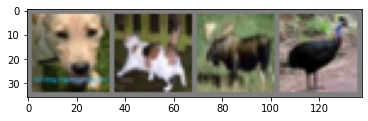

  dog   cat  deer  bird


In [87]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [88]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # the input shape in (<batch size>, 3, 32, 32)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [89]:
num_epoch = 2
lr = 0.001

net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
for epoch in range(num_epoch):
    running_loss = 0.0
    for batch_no, batch in enumerate(trainloader):
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        
        # clear gradiend buffers
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(inputs)
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        
        # weights update
        optimizer.step()
        
        running_loss += loss.item()
        if batch_no % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_no + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

exp_path = os.path.join(data_exp_dir, 'cifar_net.pth')
torch.save(net.state_dict(), exp_path)

[1,  2000] loss: 2.178
[1,  4000] loss: 1.843
[1,  6000] loss: 1.656
[1,  8000] loss: 1.557
[1, 10000] loss: 1.473
[1, 12000] loss: 1.444
[2,  2000] loss: 1.368
[2,  4000] loss: 1.360
[2,  6000] loss: 1.326
[2,  8000] loss: 1.311
[2, 10000] loss: 1.299
[2, 12000] loss: 1.282
Finished Training


In [91]:
# load the model (not necessary in this case)

loaded_net = Net()
loaded_net.to(device)
loaded_net.load_state_dict(torch.load(exp_path))

correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        
        outputs = loaded_net(images)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 56 %
Accuracy of plane : 68 %
Accuracy of   car : 64 %
Accuracy of  bird : 34 %
Accuracy of   cat : 40 %
Accuracy of  deer : 55 %
Accuracy of   dog : 37 %
Accuracy of  frog : 65 %
Accuracy of horse : 65 %
Accuracy of  ship : 71 %
Accuracy of truck : 62 %
